In [13]:

import os
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import evaluate
import argparse

In [14]:
# -----------------------
# Config / Hyperparams
# -----------------------
MODEL_NAME = "distilbert-base-uncased"   # TF-compatible checkpoint
MAX_LEN = 64
BATCH_SIZE = 5
EPOCHS = 1
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./tf_distilbert_imdb"
USE_SUBSET = True           # set True for faster local tests
TRAIN_SUBSET = 5000         # if USE_SUBSET True, number of train examples
EVAL_SUBSET = 2000          # if USE_SUBSET True, number of eval examples
SEED = 42


In [15]:
# -----------------------
# Helpers
# -----------------------
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(SEED)


In [16]:
# -----------------------
#loading the data set
print("Loading dataset...")
raw_datasets = load_dataset("imdb")
if USE_SUBSET:
    raw_train = raw_datasets["train"].shuffle(seed=SEED).select(range(TRAIN_SUBSET))
    raw_test = raw_datasets["test"].shuffle(seed=SEED).select(range(EVAL_SUBSET))
else:
    raw_train = raw_datasets["train"]
    raw_test = raw_datasets["test"]

print(f"Train size: {len(raw_train)}, Test size: {len(raw_test)}")


Loading dataset...
Train size: 5000, Test size: 2000


In [17]:
# Tokenizer & Preprocessing
# -----------------------
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess_batch(examples):
    # tokenizes a batch and returns padding/truncated tensors
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

print("Tokenizing dataset (this may take a while)...")
train_tokenized = raw_train.map(preprocess_batch, batched=True, remove_columns=["text"])
test_tokenized = raw_test.map(preprocess_batch, batched=True, remove_columns=["text"])

# keep only necessary columns and set format to numpy for generator
train_tokenized = train_tokenized.remove_columns([c for c in train_tokenized.column_names if c not in ("input_ids","attention_mask","label")])
test_tokenized = test_tokenized.remove_columns([c for c in test_tokenized.column_names if c not in ("input_ids","attention_mask","label")])

Loading tokenizer...
Tokenizing dataset (this may take a while)...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 6235.90 examples/s]


In [18]:
# Convert to tf.data.Dataset
# -----------------------
print("Building tf.data pipelines...")

def gen_from_dataset(dataset):
    # generator yields (features, label) where features is dict of arrays
    for ex in dataset:
        features = {
            "input_ids": np.array(ex["input_ids"], dtype=np.int32),
            "attention_mask": np.array(ex["attention_mask"], dtype=np.int32),
        }
        label = np.int64(ex["label"])
        yield features, label

output_signature = (
    {
        "input_ids": tf.TensorSpec(shape=(MAX_LEN,), dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=(MAX_LEN,), dtype=tf.int32),
    },
    tf.TensorSpec(shape=(), dtype=tf.int64)
)

train_tf = tf.data.Dataset.from_generator(lambda: gen_from_dataset(train_tokenized), output_signature=output_signature)
train_tf = train_tf.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_tf = tf.data.Dataset.from_generator(lambda: gen_from_dataset(test_tokenized), output_signature=output_signature)
test_tf = test_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Building tf.data pipelines...


In [19]:
import torch, transformers, safetensors
print("torch", torch.__version__)
print("transformers", transformers.__version__)
print("safetensors", getattr(safetensors, "__version__", "not installed"))


torch 2.9.1+cpu
transformers 4.57.1
safetensors 0.7.0


In [20]:
# Build / Load TF model
# -----------------------
print("Loading TF model...")
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2,from_pt=True)

# Optionally enable mixed precision for speed on modern GPUs
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Loading TF model...


KeyboardInterrupt: 

In [ ]:
# # Callbacks
# # -----------------------
# os.makedirs(OUTPUT_DIR, exist_ok=True)
# checkpoint_path = os.path.join(OUTPUT_DIR, "best_model.h5")
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_accuracy", mode="max"),
#     tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-7)
# ]
# -----------------------
# Callbacks (weights-only checkpoint)
# -----------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
checkpoint_path = os.path.join(OUTPUT_DIR, "best_weights.ckpt")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_weights_only=True,
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-7)
]



In [ ]:
# Train
# -----------------------
print("Starting training...")
history = model.fit(
    train_tf,
    validation_data=test_tf,
    epochs=1,
    callbacks=callbacks,
    verbose=1
)


Starting training...

1000/1000 [==============================] - 505s 488ms/step - loss: 0.4959 - accuracy: 0.7562 - val_loss: 0.4295 - val_accuracy: 0.8025 - lr: 2.0000e-05


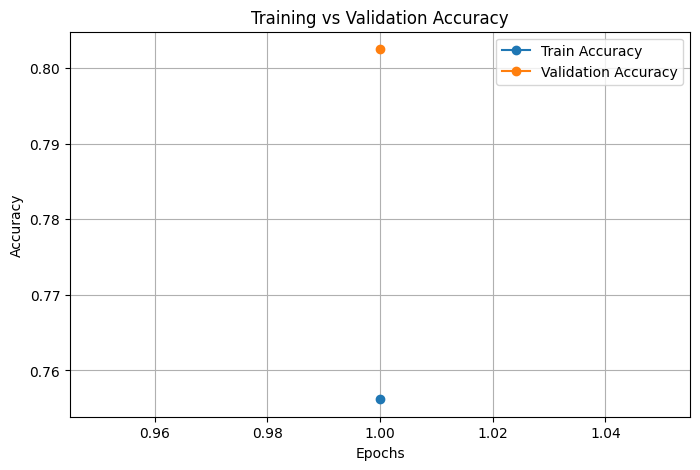

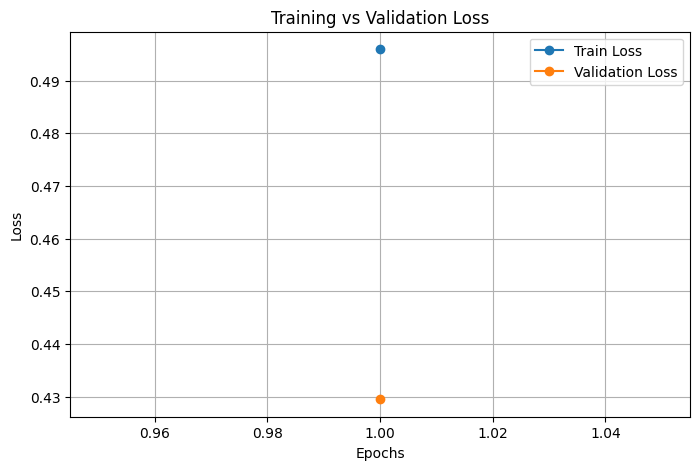

In [22]:
import matplotlib.pyplot as plt

# Extract history values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# -----------------------
# Plot Accuracy
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# Plot Loss
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Evaluate
# -----------------------
print("Loading evaluation metric...")
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

print("Evaluating on test set (batched inference)...")
# run batched inference and accumulate predictions
y_true = []
y_pred = []

for batch in test_tf:
    features, labels = batch
    logits = model(features, training=False)[0]   # (batch, num_labels)
    probs = tf.nn.softmax(logits, axis=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

acc = acc_metric.compute(predictions=y_pred, references=y_true)["accuracy"]
f1 = f1_metric.compute(predictions=y_pred, references=y_true, average="binary")["f1"]
print(f"Test Accuracy: {acc:.4f}, F1 (binary): {f1:.4f}")

Loading evaluation metric...


Evaluating on test set (batched inference)...
Test Accuracy: 0.8025, F1 (binary): 0.8111


In [23]:
# Save the model (SavedModel format)
# -----------------------
print("Saving model as SavedModel to:", OUTPUT_DIR)
model.save_pretrained(OUTPUT_DIR)   # saves HF-style weights + config (TF)

Saving model as SavedModel to: ./tf_distilbert_imdb


In [ ]:
# Quick inference util
# -----------------------
def predict_texts(texts, top_k=1):
    toks = tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="tf")
    logits = model(toks)[0]
    probs = tf.nn.softmax(logits, axis=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return preds, probs

if __name__ == "__main__":
    samples = [
        "That movie was amazing — I loved it and would watch again!",
        "Terrible film. I want my two hours back."
    ]
    p, pr = predict_texts(samples)
    for text, pred, prob in zip(samples, p, pr):
        print("TEXT:", text)
        print("PRED:", int(pred), "PROBS:", prob)
        print("----")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TEXT: That movie was amazing — I loved it and would watch again!
PRED: 1 PROBS: [0.02722527 0.97277474]
----
TEXT: Terrible film. I want my two hours back.
PRED: 0 PROBS: [0.9630021  0.03699791]
----


: 

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.20.0
[]
